## Running random forest model using k-fold cross validation

In [3]:
from os import chdir
chdir('..')
import config as cfg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestRegressor
import math

np.random.seed(14)

In [4]:
df_cand = pd.read_csv(cfg.training_candidate_file, index_col = 0)
df_money = pd.read_csv(cfg.cleaned_money_file, index_col = 0)

print(df_cand['ELECTION_DATE'].value_counts())

2016-06-07    316
2018-06-05    313
Name: ELECTION_DATE, dtype: int64


In [5]:
df_money.DONOR_ENTITY_TYPE.value_counts()

IND    82585
OTH    25901
COM    18529
SCC     5082
PTY      692
RCP      270
Name: DONOR_ENTITY_TYPE, dtype: int64

In [6]:
race_key = ['CONTEST_NAME' , 'ELECTION_DATE' ]
cand_key = [*race_key, 'CANDIDATE_NAME']

In [7]:
df = df_cand.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 20 columns):
CANDIDATE_NAME                629 non-null object
CONTEST_NAME                  629 non-null object
ELECTION_DATE                 629 non-null object
PARTY_NAME                    629 non-null object
INCUMBENT_FLAG                629 non-null int64
PARTY_LEAN                    629 non-null int64
WRITE_IN_FLAG                 629 non-null int64
VOTE_TOTAL                    629 non-null int64
CAND_TOTAL_RAISED             629 non-null float64
LEGISLATURE                   629 non-null bool
CANDIDATE_COUNT               629 non-null int64
RACE_TOTAL_RAISED             629 non-null float64
RACE_VOTE_TOTAL               629 non-null int64
VOTE_SHARE                    629 non-null float64
CAND_SHARE_OF_MONEY_RAISED    629 non-null float64
NUM_IND_DONORS                629 non-null float64
SUM_IND_DONATIONS             629 non-null float64
MONEY_FROM_PARTY              629 non-null floa

In [9]:
print(f'{df.groupby(race_key).size().size} distinct races.')
print(f'Election dates: { df["ELECTION_DATE"].unique() }.')
print(f'{df.groupby(cand_key).size().size} candidates.')
print(f'{df.groupby("PARTY_NAME").CANDIDATE_NAME.count().Republican} Republicans.')
print(f'{df.groupby("PARTY_NAME").CANDIDATE_NAME.count().Democratic} Democrats.')

200 distinct races.
Election dates: ['2016-06-07' '2018-06-05'].
629 candidates.
235 Republicans.
348 Democrats.


In [10]:
df.columns

Index(['CANDIDATE_NAME', 'CONTEST_NAME', 'ELECTION_DATE', 'PARTY_NAME',
       'INCUMBENT_FLAG', 'PARTY_LEAN', 'WRITE_IN_FLAG', 'VOTE_TOTAL',
       'CAND_TOTAL_RAISED', 'LEGISLATURE', 'CANDIDATE_COUNT',
       'RACE_TOTAL_RAISED', 'RACE_VOTE_TOTAL', 'VOTE_SHARE',
       'CAND_SHARE_OF_MONEY_RAISED', 'NUM_IND_DONORS', 'SUM_IND_DONATIONS',
       'MONEY_FROM_PARTY', 'PARTY_FAVORITE', 'IND_DONOR_RATIO'],
      dtype='object')

Adding a random variable as a feature

In [11]:
df['RANDOM_VARIABLE'] = np.random.randint(100)

In [12]:
raceFeatures = ['CANDIDATE_COUNT', 'RACE_TOTAL_RAISED', 'RACE_VOTE_TOTAL']
# raceFeatures = ['CANDIDATE_COUNT', 'RACE_TOTAL_RAISED', 'RACE_VOTE_TOTAL']

moneyFeatures = ['CAND_TOTAL_RAISED', 'CAND_SHARE_OF_MONEY_RAISED', 'NUM_IND_DONORS', 'SUM_IND_DONATIONS']
# moneyFeatures = ['CAND_TOTAL_RAISED', 'NUM_IND_DONORS', 'SUM_IND_DONATIONS']
# moneyFeatures = ['CAND_TOTAL_RAISED']
#, 'IND_DONOR_RATIO'
candFeatures = ['PARTY_LEAN', 'WRITE_IN_FLAG', 'PARTY_FAVORITE', 'IND_DONOR_RATIO']
randomFeature = ['RANDOM_VARIABLE']
features = raceFeatures + candFeatures + randomFeature +moneyFeatures
target = ['VOTE_SHARE']
print(features)

if 'ELECTION_DATE' in features:
    # Convert election dates into a binary feature
    datemap = {'2016-06-07': 0, '2018-06-05': 1}
    df['ELECTION_DATE'] = df['ELECTION_DATE'].replace(datemap)

['CANDIDATE_COUNT', 'RACE_TOTAL_RAISED', 'RACE_VOTE_TOTAL', 'PARTY_LEAN', 'WRITE_IN_FLAG', 'PARTY_FAVORITE', 'IND_DONOR_RATIO', 'RANDOM_VARIABLE', 'CAND_TOTAL_RAISED', 'CAND_SHARE_OF_MONEY_RAISED', 'NUM_IND_DONORS', 'SUM_IND_DONATIONS']


In [13]:
R =[df for _, df in df.groupby(race_key)]
random.shuffle(R)
print(len(R))
R
# R is list of dataframes, each dataframe has all candidates in just one race

200


[     CANDIDATE_NAME                       CONTEST_NAME ELECTION_DATE  \
 153    DEVON MATHIS  State Assembly Member District 26    2016-06-07   
 154  RUBEN MACARENO  State Assembly Member District 26    2016-06-07   
 155    RUDY MENDOZA  State Assembly Member District 26    2016-06-07   
 
      PARTY_NAME  INCUMBENT_FLAG  PARTY_LEAN  WRITE_IN_FLAG  VOTE_TOTAL  \
 153  Republican               1           1              0       28563   
 154  Democratic               0          -1              0       20536   
 155  Republican               0           1              0       18216   
 
      CAND_TOTAL_RAISED  LEGISLATURE  ...  RACE_TOTAL_RAISED  RACE_VOTE_TOTAL  \
 153          315551.01         True  ...          399302.14            67315   
 154            1001.13         True  ...          399302.14            67315   
 155           82750.00         True  ...          399302.14            67315   
 
      VOTE_SHARE  CAND_SHARE_OF_MONEY_RAISED  NUM_IND_DONORS  \
 153    0.4243

# Split folds
There are 200 races in this data file
Makes sense to withhold 20% as test, and do 5-fold cross-validation.

In [14]:
# Yield 5 successive  
# chunks from l. 
def divide_chunks(R, k): 
    l = len(R) // k
      
    for i in range(0, k):
        if i == k-1:
            yield R[i*l:]
        else:
            yield R[i*l: (i+1)*l] 
  
k = 5
folds = list(divide_chunks(R, k))
folds # Should be list of list of dataframes

[[     CANDIDATE_NAME                       CONTEST_NAME ELECTION_DATE  \
  153    DEVON MATHIS  State Assembly Member District 26    2016-06-07   
  154  RUBEN MACARENO  State Assembly Member District 26    2016-06-07   
  155    RUDY MENDOZA  State Assembly Member District 26    2016-06-07   
  
       PARTY_NAME  INCUMBENT_FLAG  PARTY_LEAN  WRITE_IN_FLAG  VOTE_TOTAL  \
  153  Republican               1           1              0       28563   
  154  Democratic               0          -1              0       20536   
  155  Republican               0           1              0       18216   
  
       CAND_TOTAL_RAISED  LEGISLATURE  ...  RACE_TOTAL_RAISED  RACE_VOTE_TOTAL  \
  153          315551.01         True  ...          399302.14            67315   
  154            1001.13         True  ...          399302.14            67315   
  155           82750.00         True  ...          399302.14            67315   
  
       VOTE_SHARE  CAND_SHARE_OF_MONEY_RAISED  NUM_IND_DONORS  

# apply regression

In [15]:
from sklearn.metrics import explained_variance_score, max_error, mean_squared_error, r2_score
def divide_chunks(R, k): 
    # Yield 5 successive  
    # chunks from l. 
    l = len(R) // k
      
    for i in range(0, k):
        if i == k-1:
            yield R[i*l:]
        else:
            yield R[i*l: (i+1)*l] 
  
def apply_k_fold_regression(R, k=5, **hyperparams):
    """
    Perform k-fold splitting of races, then group and apply regresion, return regressor with rmse values
    
    :param R: list of dataframes that has candidate features and vote results, each dataframe from just one race
    :param k: number of folds. Whatever is left over after the k'th fold will be added to the last fold.
    
    :param hyperparams: keyword hyperparameters to be fed to the regressor
    :returns regressor, mean_rmse, std_rmse
    """

    
    folds = list(divide_chunks(R, k))
    folds # Should be list of list of dataframes
    
    rmse_list = []
    test_score_list = []
    train_score_list = []
    for i in range(0, k):
        # i denotes the test fold, all others are train.
        test = [race for race in folds[i]]
        # Flatten all train races together
        train = [race for j, fold in enumerate(folds) for race in fold if j!=i]

        # Concat all races in all train folds together
        train = pd.concat(train)

        # Concat all test races together, into one big dataframe
        test = pd.concat(test)

        # Splitting columns.
        key_train = train[cand_key]
        X_train = train[features]
        y_train = train[target].values.ravel()
        X_test = test[features]
        y_test = test[target].values.ravel()

        reg = RandomForestRegressor(**hyperparams)

        reg.fit(X_train, y_train)
        
        y_pred = reg.predict(X_test)
        y_pred_df = pd.DataFrame(y_pred, index=test.index)
        
        # Convert to dataframe so we can look at errors by group later
        test_results = test[cand_key].copy()
        test_results['y_test'] = y_test
        test_results['y_pred'] = y_pred_df
 

    #     _normalize(test_all)
        denom = test_results.groupby(race_key).agg(sum_pct=('y_pred', 'sum'))
        test_results = test_results.set_index(cand_key)
        test_results = pd.merge(left=test_results, right = denom, left_index=True, right_index=True)
        test_results['y_pred'] = test_results['y_pred']/test_results['sum_pct']
    #     print(test_results)

        #   Scoring Function:
        def myScore(y_test, y_pred):
            return {
                'root_mean_squared_error': math.sqrt(mean_squared_error(y_test, y_pred)),
                'explained_variance': explained_variance_score(y_test, y_pred),
                'max_error': max_error(y_test, y_pred),
                'r2_score': r2_score(y_test, y_pred)
                }
        
        # Test scores   
        score = myScore(100 * test_results['y_test'], 100 * test_results['y_pred'])
        score.update(hyperparams)
        test_score_list.append(score)
#         print('Test Score \n', (80 * '.') + '\n', score, '\n', 40 * ' - ')
        
        
        
        # Training scores:
        train_y_pred = reg.predict(X_train)
        train['train_y_pred'] = pd.DataFrame(train_y_pred, index=train.index)
        score = myScore(100 * train[target], 100 * train['train_y_pred'])
        score.update(hyperparams)
        train_score_list.append(score)
#         print('Training Score \n', (80 * '.') + '\n', score, '\n', 80 * '=')
    
    testScore = {
        'rmse': np.mean([x['root_mean_squared_error'] for x in test_score_list]),
        'rmse_std': np.std([x['root_mean_squared_error'] for x in test_score_list]),
        'explained_variance': np.mean([x['explained_variance'] for x in test_score_list]),
        'explained_variance_std':  np.std([x['explained_variance'] for x in test_score_list])
    }
    testScore.update(hyperparams)
    
    trainScore = {
        'rmse': np.mean([x['root_mean_squared_error'] for x in train_score_list]),
        'rmse_std': np.std([x['root_mean_squared_error'] for x in train_score_list]),
        'explained_variance': np.mean([x['explained_variance'] for x in train_score_list]),
        'explained_variance_std':  np.std([x['explained_variance'] for x in train_score_list])
    }
    trainScore.update(hyperparams)
    return reg, testScore, trainScore

In [16]:
def plotResults(search_results):
    
    x = []
    y = []
    z = []
    for result in search_results:
        z.append(result[1]['rmse'] - result[2]['rmse'])
        y.append(result[1]['n_estimators'])
        x.append(result[1]['max_depth'])
    # library
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    %matplotlib inline

    # Make the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(y, x, z, cmap=plt.cm.viridis, linewidth=0.2)
#     plt.show()
    # to Add a color bar which maps values to colors.
    surf=ax.plot_trisurf(y, x, z, cmap=plt.cm.viridis, linewidth=0.2)
    fig.colorbar( surf, shrink=0.5, aspect=5)
#     plt.show()
    # Rotate it
    ax.view_init(30, 45)
#     plt.show()
    # Other palette
    ax.plot_trisurf(y, x, z, cmap=plt.cm.jet, linewidth=0.01)
    plt.show()
 



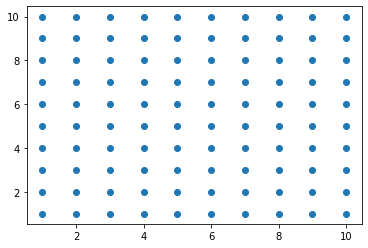

In [17]:
# depths = np..randint(40, 150, size=50)
# estims = np.random.randint(5, 40, size=50)

depths = range(1, 11, 1)
estims = range(1, 11, 1)
points = [(i, j) for i in depths for j in estims]
depths = [p[0] for p in points]
estims = [p[1] for p in points]
plt.scatter(depths, estims)


In [18]:
search_results = []
for d, e in zip(depths,estims):
    search_results.append( apply_k_fold_regression(R, k=5, n_estimators=e, max_depth=d))

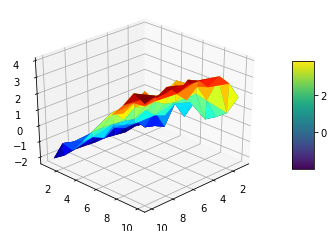

In [19]:
plotResults(search_results)

In [20]:
from joblib import dump
best = sorted(search_results, key = lambda x: (x[1]['rmse'], x[1]['rmse'] - x[2]['rmse']))
best_n_estimators = best[0][1]['n_estimators']
best_depth = best[0][1]['max_depth']
forest = best[0][0]

dump(forest, cfg.randForestModel)

print(best[0])


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False), {'rmse': 11.325359275435734, 'rmse_std': 0.8473328150184265, 'explained_variance': 0.8193274289317525, 'explained_variance_std': 0.029198194232321298, 'n_estimators': 10, 'max_depth': 10}, {'rmse': 7.647967367888404, 'rmse_std': 0.263815635942203, 'explained_variance': 0.9187870209564487, 'explained_variance_std': 0.005115083761605555, 'n_estimators': 10, 'max_depth': 10})


CAND_SHARE_OF_MONEY_RAISED: %57.51
CANDIDATE_COUNT: %8.77
RACE_TOTAL_RAISED: %8.30
RACE_VOTE_TOTAL: %7.57
WRITE_IN_FLAG: %5.29
PARTY_LEAN: %3.40
CAND_TOTAL_RAISED: %2.62
NUM_IND_DONORS: %2.49
IND_DONOR_RATIO: %1.82
SUM_IND_DONATIONS: %1.30
PARTY_FAVORITE: %0.92
RANDOM_VARIABLE: %0.00


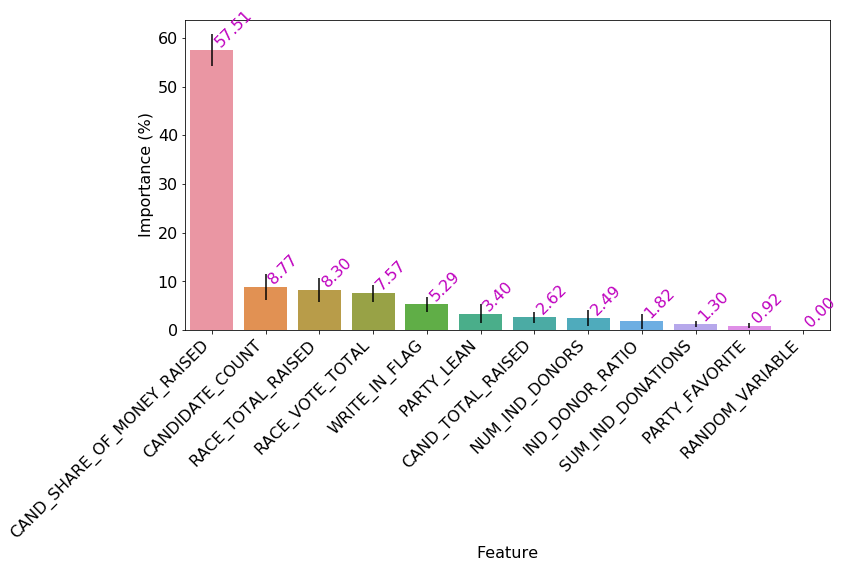

In [22]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

importances = forest.feature_importances_
zipped = sorted(list(zip(features,importances)), key=lambda x:x[1], reverse=True)
 
for f, imp in zipped:
    print(f"{f}: %{100*imp:.2f}")

plt.rc('font', **font)

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
df = pd.DataFrame({'Feature':features, 'Importance': 100 * importances, 'STD': 100 * std} )
df = df.sort_values(['Importance'], ascending=False)

fig = plt.figure(figsize=(12,8))
# plot barh chart with index as x values
ax = sns.barplot(df.Feature, df.Importance, yerr=df.STD)
# ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Feature", ylabel='Importance (%)')
# add proper Dim values as x labels
ax.set_xticklabels(df.Feature)
ax.set_xticklabels(df.Feature, rotation = 45, ha="right")
# for item in ax.get_xticklabels(): item.set_rotation(45)
for i, v in enumerate(df["Importance"].iteritems()):        
    ax.text(i ,v[1], "{:.2f}".format(v[1]), color='m', va ='bottom', rotation=45)

# plt.xticks(range(X.shape[1]), features, rotation=45)
# ax.set_xticklabels(xticklabels, rotation = 45, ha="right")

plt.tight_layout()
plt.show()


# # X = df[features]
# # Print the feature ranking
# print("Feature ranking:")



# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(features, importances,
#        color="r", yerr=std, align="center")
# plt.xlim([-1, X.shape[1]])
# plt.show()

In [25]:
fig.savefig('feat-imp.png')